# Zahn diffusivity

Works with jupyterlab3 on ppmstar.org

In [1]:
%pylab ipympl
import os,sys
from multiprocessing import Pool
from tqdm import tqdm

sys.path.insert(0,'/home/user/user/niagara_scratch_sblouin/PyPPM')
from ppmpy import ppm

lll= 2*['-', '--', ':', '-.']
markers = ['X','h','<','>','s','^','d','X','p']
random.shuffle(lll)
CB_color_cycle = ['#4daf4a', '#a65628', '#984ea3',
                  '#ff7f00', '#f781bf', '#377eb8',
                  '#999999', '#e41a1c', '#dede00']
rc('axes', prop_cycle=(cycler('color', CB_color_cycle[0:8]) +cycler('linestyle',lll)))

import collections
hydro = collections.namedtuple('hydro', ['moms','rprof'])

# turn off matplotlib messages
logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

from nugridpy import mesa as ms
from nugridpy import utils as ut
import scipy
from scipy.optimize import curve_fit

# astronomical and physical constants in SI and sgs units
from astropy import constants as const
from astropy import units as u

Msun = (const.M_sun).value
Rsun = (const.R_sun).value
Lsun = (const.L_sun).value
GN = (const.G).value  # Newton's constant 
sigma = (const.sigma_sb).value  # 1e3 tarnsforms SI units to sgs units

# transform to cgs units
GN = 1e3*GN
sigma = 1e3*sigma
Rsun = 1e2*Rsun
Msun = 1e3*Msun
Lsun = 1e7*Lsun

Populating the interactive namespace from numpy and matplotlib


## (1) Important parameter definitions

In [2]:
# the list of variables that are stored within the momsdata cube.
var_list = ['xc','ux','uy','uz','|ut|','|ur|','|w|','T','rho','fv']

In [3]:
data_dir = '/home/user/user/frontera_scratch3_mao1/'
mesacycle = [2400,12400]
runs = ['X22','X26']
heating = np.array([1000,1])
dumps = [arange(380,480,2),arange(410,510,2)]
scaling_exponent = 1/4 # alpha in vorticity \propto L^alpha
plot_labels = ['bump','tip']
run_dir = ['X22-1000xL-1000xK-heating-1536-mc2400-rin40','X26-1xL-1xK-1536-mc12400']

## (2) Load PPMstar r profiles

In [4]:
rprof = {}
rprofbq = {}
for i,run in enumerate(runs):
    rprof_dir = os.path.join(data_dir,run_dir[i],'prfs')
    rprof[run] = ppm.RprofSet(rprof_dir)
    rprofbq[run] = ppm.RprofSet(rprof_dir, bqav=True, var_list=var_list)

483 rprof files found in '/home/user/user/frontera_scratch3_mao1/X22-1000xL-1000xK-heating-1536-mc2400-rin40/prfs/.
Dump numbers range from 0 to 482.
200 rprof files found in '/home/user/user/frontera_scratch3_mao1/X22-1000xL-1000xK-heating-1536-mc2400-rin40/prfs/frombqavs/.
Dump numbers range from 281 to 480.
516 rprof files found in '/home/user/user/frontera_scratch3_mao1/X26-1xL-1xK-1536-mc12400/prfs/.
Dump numbers range from 0 to 515.
166 rprof files found in '/home/user/user/frontera_scratch3_mao1/X26-1xL-1xK-1536-mc12400/prfs/frombqavs/.
Dump numbers range from 320 to 515.


In [5]:
cvz_position = []
radius = {}
vorticity = {}
for i,run in enumerate(runs):
    for j,dump in enumerate(dumps[i]):
        w_momst, r_moms = rprofbq[run].get('|w|',dump), rprofbq[run].get('xcmax',dump)
        if j==0:
            w_moms = w_momst
        else:
            w_moms += w_momst
    w_moms = w_moms/len(dumps[i])
    radius[run] = r_moms
    vorticity[run] = w_moms

In [6]:
N2 = {}
K = {}
for i,run in enumerate(runs):
    dump = int(mean(dumps[i]))
    R = rprof[run].get('R',dump)
    N2_full_res = rprof[run].compute_N2(dump)
    N2_inter = interp(radius[run], R[::-1], N2_full_res[::-1])
    N2[run] = N2_inter#/((pi*2)**2)
    K_full_res = rprof[run].compute_Drad(dump)
    K[run] = interp(radius[run], R[::-1], K_full_res[::-1])/heating[i]

## (3) Verifications

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'N ($\\mu$Hz)')

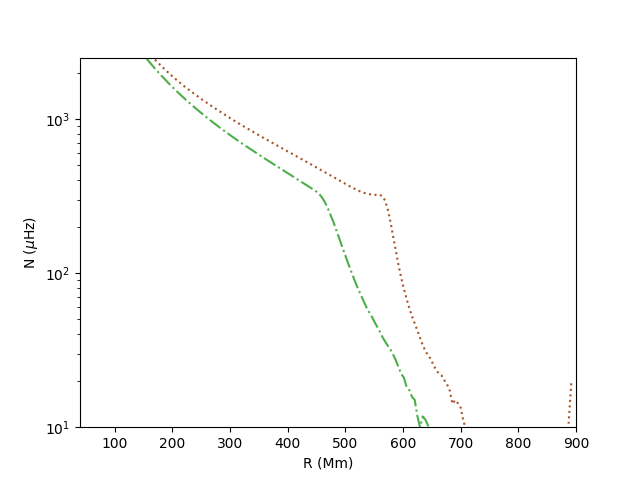

In [7]:
close(1);figure(1)
for i,run in enumerate(runs):
    semilogy(radius[run], sqrt(N2[run])*1e6)
xlim(40,900)
ylim(10,2500)
xlabel('R (Mm)')
ylabel('N ($\mu$Hz)')

(200.0, 800.0)

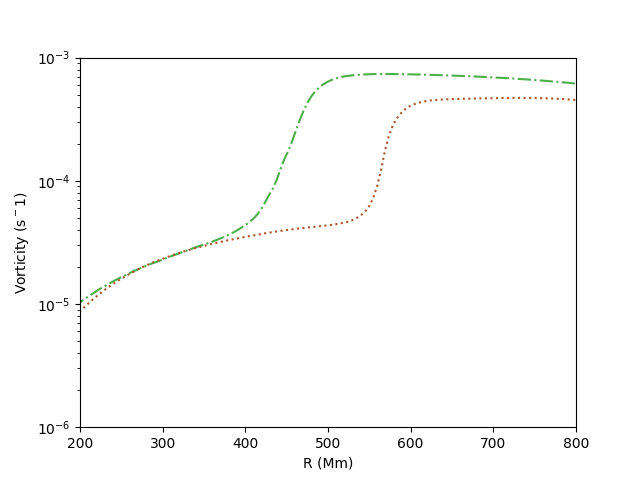

In [8]:
close(2);figure(2)
for i,run in enumerate(runs):
    semilogy(radius[run], vorticity[run])
xlim(40,900)
ylim(1e-6,1e-3)
xlabel('R (Mm)')
ylabel('Vorticity (s$^-1$)')
xlim(200,800)

(200.0, 800.0)

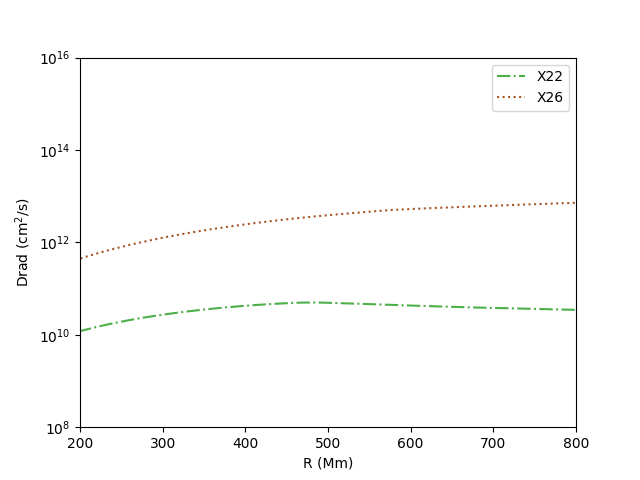

In [9]:
close(3);figure(3)
for i,run in enumerate(runs):
    semilogy(radius[run], K[run],label=run)
legend()
xlim(40,900)
ylim(1e8,1e16)
xlabel('R (Mm)')
ylabel('Drad (cm$^2$/s)')
xlim(200,800)

## (4) Diffusivity from Zahn's formula

In [10]:
def doublef(z,f1,f2,z2):
    global Hp,D0
    D2 = D0*exp(-2*z2/f1/Hp)
    Dcbm = D2*exp(-2*(z-z2)/f2/Hp)
    D1 = D0*exp(-2*z/f1/Hp)
    D = D1
    D[z>z2] = Dcbm[z>z2]
    return log10(D)

In [11]:
matplotlib.rcParams.update({'font.size': 12})

      f1    f2    D0    D2
bump  0.081 0.269  8.66  6.42
tip   0.057 0.499 11.80 10.17


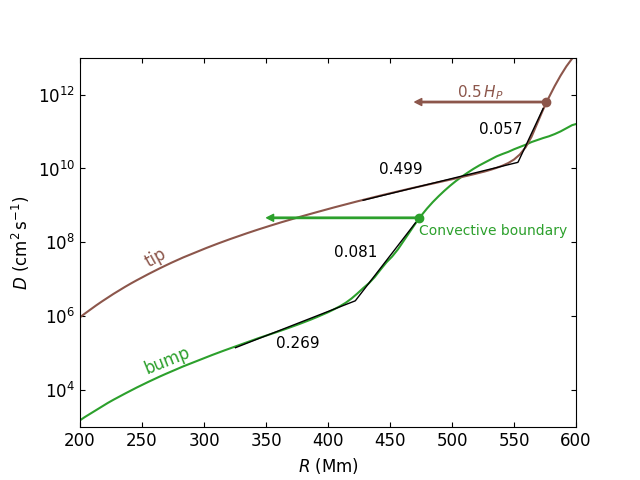

In [13]:
close(111);figure(111)

minxshow = [450,600]
maxxshow = [690,800]

angle = [22,29]

colors = ['tab:green', 'tab:brown']

eta = 0.1

print('      f1    f2    D0    D2')
for i,run in enumerate(runs):
    # diffusivity from Zahn formula
    vorticity_nominal = (1/heating[i])**(scaling_exponent) * vorticity[run]
    ans = eta*K[run]*vorticity_nominal**2/N2[run]
    semilogy(radius[run], ans, ls='-', color=colors[i])
    rlabel = 250
    text(rlabel,1.5*interp(rlabel,radius[run][::-1],ans[::-1]),plot_labels[i],
         rotation=angle[i],va='bottom',color=colors[i],fontsize=12)
        
    # add CB
    cp = rprof[run].bound_rad(cycles=dumps[i],r_min=200,r_max=800,var='|Ut|',criterion='max_grad') 
    cp = mean(cp)
    cpy = np.interp(cp,radius[run][::-1],ans[::-1])
    plot(cp, cpy, 'o', color=colors[i])
    
    # add Hp
    radius2 = rprof[run].get('R',int(np.mean(dumps[i])))
    Hpv = rprof[run].compute_Hp(int(np.mean(dumps[i])))
    Hp = interp(cp, radius2[::-1], Hpv[::-1])
    annotate('', xy=(cp-Hp*0.5, cpy), xytext=(cp, cpy), 
            arrowprops=dict(facecolor=colors[i], 
                            edgecolor=colors[i], width=1, headwidth=5, headlength=5),)
    if i==0:
        text(cp,cpy*.7,'Convective boundary',va='top',color=colors[i],size=10)
    if i==1:
        text((2*cp-0.5*Hp)/2,cpy,r'$0.5\,H_P$',va='bottom',color=colors[i],size=11, ha='center')
    
    # fit f1 and f2
    dx = 150
    mask = (radius[run]<cp)&(radius[run]>cp-dx)
    x = radius[run][mask]
    z = cp-radius[run][mask]
    y = ans[mask]
    D0 = interp(cp, radius[run][::-1], ans[::-1])
    popt, pcov = curve_fit(doublef, z, log10(y), p0=[0.1,0.5,50])
    xplot = np.linspace(min(x),max(x),500)
    zplot = cp-xplot
    if i==1:
        plot(xplot, 10**doublef(zplot,popt[0],popt[1],popt[2]),'-k',linewidth=1,label='double-$f$ fit')
        text(.91*xplot[-1], .2*10**doublef(zplot,popt[0],popt[1],popt[2])[-1],"{:.3f}".format(popt[0]),
            fontsize=11)
        text(1.03*xplot[0], 5*10**doublef(zplot,popt[0],popt[1],popt[2])[0],"{:.3f}".format(popt[1]),
            fontsize=11)
    else:
        plot(xplot, 10**doublef(zplot,popt[0],popt[1],popt[2]),'-k',linewidth=1)
        text(0.86*xplot[-1], 0.12*10**doublef(zplot,popt[0],popt[1],popt[2])[-1],"{:.3f}".format(popt[0]),
            fontsize=11)
        text(1.1*xplot[0], 10**doublef(zplot,popt[0],popt[1],popt[2])[0],"{:.3f}".format(popt[1]),
            fontsize=11)
    f1,f2,z2 = popt
    D2 = D0*exp(-2*z2/f1/Hp)
    print(plot_labels[i].ljust(5)+' '+"{:.3f}".format(f1)+' '+"{:.3f}".format(f2)+
          ' '+"{:.2f}".format(log10(D0)).rjust(5)+' '+"{:.2f}".format(log10(D2)).rjust(5))
    
xlabel(r'$R$ (Mm)')
ylabel(r'$D$ (cm$^2\,$s$^{-1}$)')
ax = plt.gca()
ax.tick_params(axis='both',direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
xlim(200,600)
ylim(1e3,1e13)
#legend(frameon=False)

# add Texascale results
# plot([450],[10**7.92],'o',color=colors[1])
# plot([550],[10**7.7],'v',color=colors[1])

savefig('Dzahn.pdf', bbox_inches='tight')